# Dynamic indirect and direct storage for Dry Creek 

Import libraries. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import glob
import pickle
import scipy
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
import datetime

# Helper functions

Define a few functions to help with simple interception modeling, computation of the catchment sensitivity function [$g(Q)$], and determining boundaries for binning samples of $\Delta Q/\Delta t$. 

In [2]:
# Rainfall interception function
def intercept_rain(ppt, interception_depth):
    freq = ppt.index.freq
    idx = ppt.index.copy()
    prcp = ppt.copy()
    precip_pre = ppt.ppt.resample('D').mean()+1e-12
    precip_post = precip_pre.apply(lambda x: np.max([0,x-interception_depth])) 
    frac_int = (precip_pre.sum() - precip_post.sum())/precip_pre.sum()
    print('Fraction intercepted = %.2f'%frac_int)
    rng = pd.date_range(precip_post.index[0], precip_post.index[-1], freq=freq)
    daily_multiplication_factor = precip_post/precip_pre
    daily_multiplication_factor = pd.DataFrame({'factor':daily_multiplication_factor.resample(freq,how='ffill').tolist()},index=rng)
    ppt.ppt = daily_multiplication_factor.factor*prcp.ppt
    return ppt

# Sensitivity function [see Kirchner, 2009] doi:10.1029/2008WR006912
def g(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]

# Bin dq/dt data
def KirchnerBinning(df, min_per_bin = 10, loud=False):
    df = df.sort_values('q',ascending=False)
    
    logQ = np.array(np.log(df.q))
    
    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*.01
  
    binBoundaries = [0]
    for i in range(1,len(df)):    
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize: 
            if loud: print('Bin too small')
            continue
            
        if abs(i-binBoundaries[-1]) < min_per_bin:
            if loud: print('Not enough data points')
            continue  
            
        curr = df.dq[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2: 
            if loud: print('Bin too heterogeneous')
            continue    
        
        binBoundaries.append(i)
    return binBoundaries

# Recession analysis

Here, we extract hydrograph recession segments to estimate $dQ/dt$ during periods when $P, E \ll Q$. 

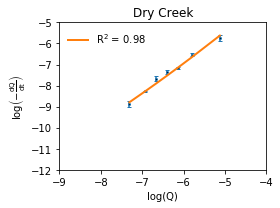

In [3]:
# Load rainfall and flow data
ppt = pd.read_pickle('./data/dry_ppt.p')
df = pd.read_pickle('./data/df_dry.p')

# Lag in days after neglible rainfall before analysis starts
rainfall_lag = 1.0
mean_fraction = 0.001

# Keep tabs on rainfall total of previous rainfall_lag days
rainfall_lag *= (24*60*60.)

# Resample to daily 
freq = '1D'
ppt = ppt.resample(freq).mean()
df = df.resample(freq).mean()
x = df.index.freq
num_secs = x.delta.days*(60*60*24) + x.delta.seconds
dt = num_secs/(24.*60*60)
lag = int(rainfall_lag/num_secs)
meanQ = np.mean(df.q)

# Lists to store q and its derivative
dqs = []
qs = []
years = list(set(ppt.index.year))
years.sort()
for year in years:
    # Do not loop beyond the 2017 water year, which starts in 2016
    if year==2017:
        continue
        
    # Only use winter month recessions
    startdate = '11-' + str(year)
    enddate = '3-' + str(year+1)
    rain = np.array(ppt.ppt.loc[startdate:enddate])
    runoff = np.array(df.q.loc[startdate:enddate])
    i = lag
    while i<len(rain):
        # Too much rain
        if np.sum(dt*rain[i-lag:i+1]) > .002:
            i+=1
            continue

        # We have found period of negligible rainfall 
        # Find index of next day of rainfall 
        idx_next_rain = np.where(rain[i+1:]>0)[0]
        if len(idx_next_rain)>0:
            idx_next_rain = idx_next_rain[0] + (i+1)
        else: 
            # no more rain for this particular year
            break
        
        # too short of a rainless period for analysis 
        if idx_next_rain==i+1: 
            i += 2
            continue
        
        # get dq/dt going forward, not including the next day of rainfall
        for j in range(i, idx_next_rain):
            q_diffs = runoff[j] - runoff[j+1:idx_next_rain]
            idx_end = np.where(q_diffs>mean_fraction*meanQ)[0]
            if len(idx_end)>0:
                idx_end = idx_end[0]
                qs.append((runoff[j] + runoff[j+idx_end+1])/2)
                dqs.append((runoff[j+idx_end+1]-runoff[j])/(dt*(idx_end+1)))
            else:
                i = idx_next_rain + lag + 1
                break 

        i = idx_next_rain + lag + 1
        
qs = np.array(qs)
dqs = np.array(dqs)
df_kirchner = pd.DataFrame({'q':qs, 'dq':dqs})
df_kirchner = df_kirchner.sort_values('q',ascending=False)
binBoundaries = KirchnerBinning(df_kirchner, min_per_bin=7)
qs = [np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)]
dqs =   np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12
p = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=2, w=1/sigmas**2)
f = plt.figure(figsize=(4,3))
plt.errorbar(np.log(qs), np.log(-dqs), yerr = sigmas,fmt='o',capsize=2,**{'ms':2, 'mfc':'k','zorder':1})
x = np.log(qs)
coefficient_of_dermination = r2_score(np.log(-dqs), p[2] + p[1]*x + p[0]*x**2)
plt.plot(x, p[2] + p[1]*x + p[0]*x**2,lw=2, label='$\mathrm{R^2}$ = %.2f'%coefficient_of_dermination,zorder=10)
p[1] = p[1]-1
plt.xlabel('log(Q)')
leg = plt.legend(fontsize=10,loc='best')
leg.set_frame_on(False)
plt.ylim([-12,-5])
plt.xlim([-9,-4])
plt.title('Dry Creek',fontsize=12)
ax = f.get_axes()[0]
plt.ylabel(r'$\log \left( -\mathrm{\frac{dQ}{dt}}\right)$', color='k')
plt.tight_layout()
plt.savefig('./figures/dqdt_vs_q_dry.pdf')

In [4]:
# Reload rainfall and PET
ppt = pd.read_pickle('./data/dry_ppt.p')
pet = pd.read_pickle('./data/dry_pet.p')
ppt = ppt.resample(freq).mean()
pet = pet.resample(freq).mean()

# 1 mm/day at Dry Creek
interception_depth = 0.001
ppt = intercept_rain(ppt, interception_depth)

# Now use sensitivity function to compute direct storage time series for each year
years = list(set(df.index.year))
years.sort()
df['direct_storage'] = 0 
# only track for 2016-2017 water year
for year in [2016]: 
    startDate = '10-01-' + str(year)
    endDate = '5-1-' + str(year+1)
    thisYear = df.loc[startDate:endDate]
    # cumulative integral of dynamic storage for this water year, assuming we start at 0        
    qvar = thisYear.q.tolist()
    direct_S = [0]
    for i in range(1,len(qvar)):
        qi = qvar[i]
        qi1 = qvar[i-1]
        if qi1<=0:
            direct_S.append(0)
            continue
            
        qintegrate = np.linspace(qi1, qi, 100)
        direct_S.append(direct_S[i-1] + np.trapz([1/gg for gg in g(qintegrate,p)],qintegrate))
        if direct_S[i] < 0: 
            direct_S[i] = 0
    df['direct_storage'].loc[startDate:endDate] = direct_S

Fraction intercepted = 0.04


In [5]:
df['indirect_storage'] = 0
df['total'] = 0
for year in [2016]: 
    startDate = '10-1-' + str(year)
    endDate = '6-1-' + str(year+1)
    idx = ppt.ppt.loc[startDate:endDate].index
    thisYear = df.loc[idx]
    petYear = pet.pet.loc[idx].values
    direct_year = df['direct_storage'].loc[idx].values
    cumQ = np.array(dt*thisYear.q.cumsum())
    rain = np.array(ppt.ppt.loc[idx].ffill())
    cumRain = np.array(dt*ppt.ppt.loc[idx].ffill().cumsum())
    indirect_year = np.zeros(np.shape(cumRain))
    
    for i in range(1,len(indirect_year)):
        iyt = cumRain[i] - cumQ[i] - np.cumsum(petYear*dt)[i] - direct_year[i]
        if iyt<0:
            petYear[i] = 0
        indirect_year[i] = cumRain[i] - cumQ[i] - np.cumsum(petYear*dt)[i] - direct_year[i]
    total = cumRain - cumQ - np.cumsum(petYear)*dt
    indirect_year_df = pd.DataFrame(indirect_year, index=idx).resample('D').mean()
    direct_year_df = pd.DataFrame(direct_year, index=idx).resample('D').mean()
    df['indirect_storage'].loc[idx] = indirect_year
    df['total'].loc[idx] = total

df = 1000*df

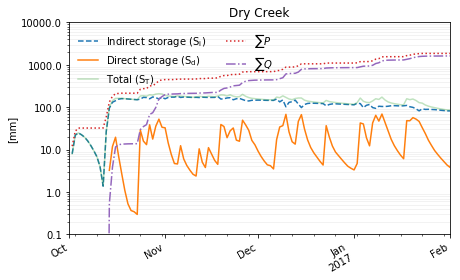

In [6]:
start_date = '10-2016'
end_date = '2-2017'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
df.indirect_storage.plot(style='--',linewidth=1.5, ax=ax1)
labels.append('Indirect storage ($\mathrm{S}_\mathrm{i}$)')
df.direct_storage.plot(linewidth=1.5, ax=ax1)
labels.append('Direct storage ($\mathrm{S}_\mathrm{d}$)')
df.total.plot(linewidth=1.5, ax=ax1, alpha=0.3)
labels.append('Total ($\mathrm{S}_\mathrm{T}$)')

pcumulative = ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000
qcumulative = df.q.loc[start_date:end_date].cumsum()*dt
pcumulative.plot(style=':', lw=1.5)
labels.append('$\sum P$')
qcumulative.plot(style='-.', lw=1.5)
labels.append('$\sum Q$')

ax1.set_xlim([start_date,end_date])
if uselog:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-1,1e4])
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    ax1.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.5, alpha=0.1)
else:
    ax1.set_ylim([0,2000])
    ax1.grid(**{'ls':'--', 'lw':0.3})


ax1.set_title('Dry Creek')

leg = ax1.legend(labels, loc='upper left', ncol=2)
leg.set_frame_on(False)
ax1.set_ylabel('[mm]')
ax1.set_xlabel('')
f.autofmt_xdate()
plt.tight_layout()
plt.savefig('./figures/dry_' + start_date + '_' + end_date + '.pdf')

In [7]:
idx = (df.index.month>=12)|(df.index.month<=2)
ismean = 1*df.indirect_storage.loc[idx].mean()
isstd = np.std(1*df.indirect_storage.loc[idx])
iscv = isstd/ismean
dsmean = 1*df.direct_storage.loc[idx].mean()
dsstd = np.std(1*df.direct_storage.loc[idx])
dscv = dsstd/dsmean
printstr = 'All winter months: indirect storage mean = %.2f pm %.2f, cv = %.2f; direct mean = %.2f, cv = %.2f'%(ismean, isstd, iscv, dsmean, dscv)
print(printstr)

All winter months: indirect storage mean = 43.40 pm 53.72, cv = 1.24; direct mean = 12.26, cv = 1.51


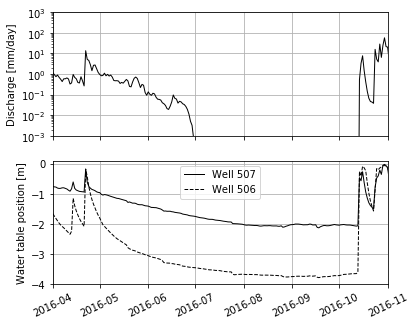

In [8]:
wells_df = pd.read_csv('./data/level4e.csv', date_parser=True)
wells_df['date'] = pd.to_datetime(wells_df['Unnamed: 0'])
wells_df = wells_df.set_index('date')
wellname = 'WELL 507 (Water level from surface (m))'
second_well = 'WELL 506 (Water level from surface (m))'

f, (ax1, ax2) = plt.subplots(2,figsize=(6,5), sharex=True)
wells_df['Dry Creek runoff [mm/day]'] = wells_df['dryRunoff_mmDay^-1']
wells_df = wells_df[[second_well,wellname,'Dry Creek runoff [mm/day]']]
startdate = '4-2016'
enddate = '11-2016'
wells_df['Dry Creek runoff [mm/day]'] += 1e-12
ax1.plot(wells_df['Dry Creek runoff [mm/day]'].resample('D').mean().loc[startdate:enddate],c='k', linewidth=1)
ax1.set_yscale('log')
ax1.set_ylabel('Discharge [mm/day]')
ax1.set_ylim([1e-3,1e3])

wells_df['grad'] = np.gradient(wells_df[wellname])
dftemp = wells_df.loc[startdate:enddate]
ax2.plot(dftemp[wellname].loc[wells_df[wellname]>-2.2].resample('D').mean(),c='k',label='Well 507', linewidth=1)
ax2.plot(dftemp[second_well].loc[wells_df[second_well]>-4].resample('D').mean(),'--',c='k',label='Well 506', linewidth=1)
ax2.legend()

ax2.set_ylabel('Water table position [m]')
labs = ax2.get_xticklabels()
x = ax2.get_xticks()
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)
    
ax1.grid(True)    
ax2.grid(True)
ax1.set_xlim(['4-2016','11-2016'])
ax2.set_xlim(['4-2016','11-2016'])


ax2.set_ylim([-4,0.1])
f.savefig('./figures/well_hydrograph.pdf')

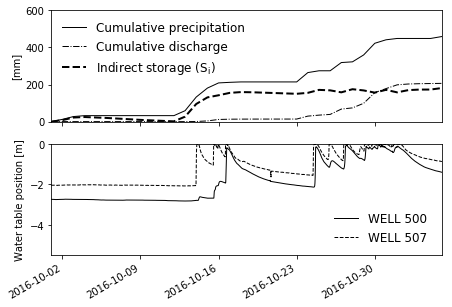

In [9]:
wells_df = pd.read_csv('./data/level4e.csv', date_parser=True)
wells_df['date'] = pd.to_datetime(wells_df['Unnamed: 0'])
wells_df = wells_df.set_index('date')
colnames = []
for col in wells_df.columns:
    if ('WELL' in col)&(('507' in col)|('500' in col)): 
        colnames.append(col)
wells_df = wells_df[colnames]
for i,col in enumerate(colnames):
    colnames[i] = col[0:9]
wells_df.columns = colnames

start_date = '10-1-2016'
end_date = '11-5-2016'
f, (ax1, ax2) = plt.subplots(2, figsize=(7,5))

cp = ['k-', 'k--', 'C3']
for i,col in enumerate(colnames):
    if 'MN-1' in col:
        welltemp = wells_df[col].loc[start_date:end_date]
        welltemp = welltemp.loc[welltemp>-1.9]
        ax2.plot(welltemp,linestyle=cp[i], linewidth=2,label=col)


    else:
        ax2.plot(wells_df[col].loc[wells_df[col]>-4], cp[i], linewidth=1, label=col)


ax1.plot(ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000,'k-', label='Cumulative precipitation', linewidth=1)
ax1.plot(df.q.loc[start_date:end_date].cumsum()*dt,'k-.',label='Cumulative discharge', linewidth=1)
ax1.plot(df.indirect_storage, 'k--', label='Indirect storage ($\mathrm{S}_\mathrm{i}$)',linewidth=2)
ax1.set_xlim([start_date,end_date])
ax2.set_xlim([start_date,end_date])
ax1.set_ylim([0,600])
ax2.set_ylim([-5.5,0])

ax1.set_ylabel('[mm]')
ax2.set_ylabel('Water table position [m]')
leg1 = ax1.legend(loc='upper left', fontsize=12)
leg2 = ax2.legend(loc='lower right', fontsize=12)
leg2.draw_frame(False)
leg1.draw_frame(False)
labs = ['' for i in range(len(ax1.get_xticklabels()))]
ax1.set_xticklabels(labs)
f.autofmt_xdate()
f.savefig('./figures/wt_indirect.pdf')

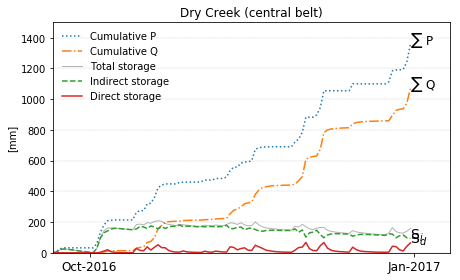

In [11]:
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=16)
fig, (ax) = plt.subplots(1,figsize=(6.5,4))
start_date = '10-2016'
end_date = '1-09-2017'
indirect = df.indirect_storage.loc[start_date:end_date].values
direct = df.direct_storage.loc[start_date:end_date].values
total = df.total.loc[start_date:end_date].values
prcp = ppt.ppt.loc[start_date:end_date].cumsum().values*dt*1000
dis = df.q.loc[start_date:end_date].cumsum().values*dt

idx = df.loc[start_date:end_date].index.to_pydatetime()

x0, y0i = idx[0], indirect[0]
y0d = direct[0]
y0t = total[0]
y0p = prcp[0]
y0q = dis[0]

lp, = ax.plot(x0, y0p,':', label='Cumulative P', lw=1.5)
lq, = ax.plot(x0, y0q,'-.', label='Cumulative Q', lw=1.5)
lt, = ax.plot(x0, y0t, label='Total storage',c='k',linewidth=1., alpha=0.3)
li, = ax.plot(x0, y0i,'--', label='Indirect storage',linewidth=1.5)
ld, = ax.plot(x0, y0d, label='Direct storage',linewidth=1.5)

ai = ax.annotate('S$_i$', [x0, y0i])
ap = ax.annotate('$\sum$ P', [x0, y0p])
aq = ax.annotate('$\sum$ Q', [x0, y0q])
ad = ax.annotate('S$_d$', [x0, y0d])

# ai = ax.annotate('S$_i$', [idx[-1], indirect[-1]])
# ap = ax.annotate('$\sum$ P', [idx[-1], prcp[-1]])
# aq = ax.annotate('$\sum$ Q', [idx[-1], dis[-1]])
# ad = ax.annotate('S$_d$', [idx[-1], direct[-1]])


uselog=False
leg = ax.legend(loc='upper left', ncol=1)
if uselog==False:
    ax.set_ylim([0,1500])
    ax.set_xlim([idx[0], idx[-1]+datetime.timedelta(days=10)])

else:
    ax.set_yscale('log')
    ax.set_ylim([1e-1,1e4])

ax.set_title('Dry Creek (central belt)')
ax.grid(axis='y', **{'ls':'--', 'lw':0.3})
leg.set_frame_on(False)
# ax.set_xlim([idx[0], idx[-1]+datetime.timedelta(days=10)])
ax.set_ylabel('[mm]')
ticks = [idx[10], idx[-1]]
ax.set_xticks(ticks)
labels = [ticks[i].strftime('%b-%Y') for i in range(len(ticks))]
ax.set_xticklabels(labels, fontsize=12)
plt.xticks(rotation=0)
fig.tight_layout()


with writer.saving(fig, "./figures/dry_video.mp4", 200):
    for i in range(1,len(indirect)):
        y0i = (indirect[:i])
        y0d = (direct[:i])
        y0t = (total[:i])
        y0p = prcp[:i]
        y0q = dis[:i]
        
        x0 = (idx[:i])
        
        li.set_data(x0, y0i)
        ld.set_data(x0, y0d)
        lt.set_data(x0, y0t)
        lp.set_data(x0, y0p)
        lq.set_data(x0, y0q)
        
        ai.remove()
        ap.remove()
        aq.remove()
        ad.remove()
        ap = ax.annotate('$\sum$ P', [x0[-1], y0p[-1]], fontsize=12)
        aq = ax.annotate('$\sum$ Q', [x0[-1], y0q[-1]], fontsize=12)
        ad = ax.annotate('S$_d$', [x0[-1], y0d[-1]], fontsize=14)
        ai = ax.annotate('S$_i$', [x0[-1], y0i[-1]], fontsize=14)

        writer.grab_frame()

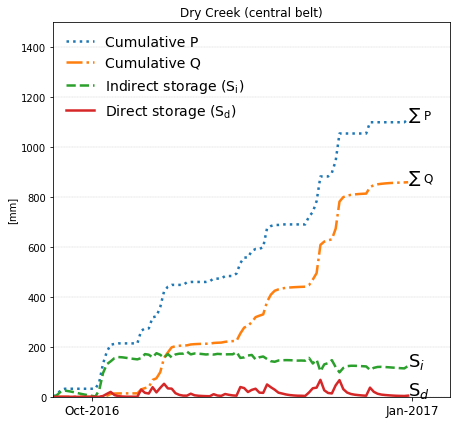

In [16]:
fig, (ax) = plt.subplots(1,figsize=(6.5,6))
start_date = '10-2016'
end_date = '1-03-2017'
indirect = df.indirect_storage.loc[start_date:end_date].values
direct = df.direct_storage.loc[start_date:end_date].values
total = df.total.loc[start_date:end_date].values
prcp = ppt.ppt.loc[start_date:end_date].cumsum().values*dt*1000
dis = df.q.loc[start_date:end_date].cumsum().values*dt

idx = df.loc[start_date:end_date].index.to_pydatetime()

x0, y0i = idx[0], indirect[0]
y0d = direct[0]
y0t = total[0]
y0p = prcp[0]
y0q = dis[0]

lp, = ax.plot(x0, y0p,':', label='Cumulative P', lw=2.5)
lq, = ax.plot(x0, y0q,'-.', label='Cumulative Q', lw=2.5)
# lt, = ax.plot(x0, y0t, label='Total storage',c='k',linewidth=1., alpha=0.3)
li, = ax.plot(x0, y0i,'--', label='Indirect storage ($\mathrm{S_i}$)',linewidth=2.5)
ld, = ax.plot(x0, y0d, label='Direct storage ($\mathrm{S_d}$)',linewidth=2.5)


ai = ax.annotate('S$_i$', [idx[-1], indirect[-1]])
ap = ax.annotate('$\sum$ P', [idx[-1], prcp[-1]])
aq = ax.annotate('$\sum$ Q', [idx[-1], dis[-1]])
ad = ax.annotate('S$_d$', [idx[-1], direct[-1]])


uselog=False
leg = ax.legend(loc='upper left', ncol=1, fontsize=14)
if uselog==False:
    ax.set_ylim([0,1500])
else:
    ax.set_yscale('log')
    ax.set_ylim([1e-1,1e4])

ax.set_title('Dry Creek (central belt)')
ax.grid(axis='y', **{'ls':'--', 'lw':0.3})
leg.set_frame_on(False)
ax.set_xlim([idx[0], idx[-1]+datetime.timedelta(days=10)])
ax.set_ylabel('[mm]')
ticks = [idx[10], idx[-1]]
ax.set_xticks(ticks)
labels = [ticks[i].strftime('%b-%Y') for i in range(len(ticks))]
ax.set_xticklabels(labels, fontsize=12)
plt.xticks(rotation=0)
fig.tight_layout()


# with writer.saving(fig, "./figures/elder_video.mp4", 200):
for i in range(1,len(indirect)):
    y0i = (indirect[:i])
    y0d = (direct[:i])
    y0t = (total[:i])
    y0p = prcp[:i]
    y0q = dis[:i]

    x0 = (idx[:i])

    li.set_data(x0, y0i)
    ld.set_data(x0, y0d)
#     lt.set_data(x0, y0t)
    lp.set_data(x0, y0p)
    lq.set_data(x0, y0q)

    ai.remove()
    ap.remove()
    aq.remove()
    ad.remove()
    ap = ax.annotate('$\sum$ P', [x0[-1], y0p[-1]], fontsize=12)
    aq = ax.annotate('$\sum$ Q', [x0[-1], y0q[-1]], fontsize=12)
    ad = ax.annotate('S$_d$', [x0[-1], y0d[-1]], fontsize=18)
    ai = ax.annotate('S$_i$', [x0[-1], y0i[-1]], fontsize=18)
    
fig.savefig('/Users/daviddralle/Dropbox/Prez and Proposals/2017/AGU/dry_creek.pdf')
#         writer.grab_frame()